In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy import stats
from astropy.io import fits

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math


In [3]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [4]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [5]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')

am.xants = []


In [6]:

v = deepcopy(uv)


In [7]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))


In [8]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)


In [9]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 2.*np.pi / B
    
    tau = dist / c
    
    temp = np.zeros((60,1024,4))
    
    T = uv.Ntimes*10
    
    del_nu = 2.*np.pi / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(int(math.ceil(float(tau/del_tau)))):
            
            temp[i][j][0]= np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
            if (i != 0):
            
                temp[-i][j][0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
    result = np.fft.fftn(temp)
    
    return result


In [10]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
  

In [11]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [12]:

def noise(amp,width):
    
    result = np.random.normal(amp,width,(60,1024,4))
    
    return result


In [13]:

ants = uv.antenna_numbers

ant_delay = {}

for i in ants:
    
    ant_delay[i] = np.random.normal(0,2e-7)
    #ant_delay[i] = np.random.randint(10)
    

In [14]:

def generate_random_data(i_width,x_width):
    
    new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)
    
    s_amp = 0
    
    s_width = 1
    
    i_amp = 0
    
    n_amp = 0
    
    n_width = 0.1
    
    xant = 23

    x_amp = 0
    
    snr = 10
    
    for i in reds:
        
        sig = signal(s_amp,s_width,i[0])
        
        for j in i:
            
            sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            indices = v.antpair2ind(j[0],j[1])
        
            i_sig = signal(i_amp,i_width,j)
            
            i_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            if ((j[0] == xant) or (j[1] == xant)):
            
                x_sig = signal(x_amp,x_width,j)
            
                x_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2 + x_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig + x_sig) * ratio
            
            else:
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig) * ratio
            
            noi = noise(n_amp,n_width)
        
            noi_power = np.mean(np.abs(noi))
        
            sig_power = np.mean(np.abs(sigs))
        
            noi_mod = snr/(sig_power/noi_power)
        
            noi /= noi_mod
            
            visibility = sigs + noi
            
            new_data_array[indices,0,:,:] = visibility
            
            
    for k in nonreds:
        
        sig = signal(s_amp,s_width,k)
        
        i_sig = signal(i_amp,i_width,j)
        
        norm_power = float(s_width**2)
        
        new_power = float(norm_power + i_width**2)
        
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig) * ratio
        
        indices = v.antpair2ind(k[0],k[1])
        
        noi = noise(n_amp,n_width)
        
        noi_power = np.mean(np.abs(noi))
        
        sig_power = np.mean(np.abs(sigs))
        
        noi_mod = snr/(sig_power/noi_power)
        
        noi /= noi_mod
        
        visibility = sig
        
        new_data_array[indices,0,:,:] = visibility
        
        return new_data_array


In [15]:

def new_compute_median_auto_power_dict(data, pols, reds):
    
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.mean(np.abs(data.get_data(i, j, pol))**2, axis=1))
    return autoPower


In [16]:
def new_red_corr_metrics(data, pols, antpols, ants, reds, xants=[], rawMetric=False, crossPol=False):

    # Compute power correlations and assign them to each antenna
    autoPower = new_compute_median_auto_power_dict(data, pols, reds)
    antCorrs = {(ant, antpol): 0.0 for ant in ants for antpol in antpols if
                (ant, antpol) not in xants}
    antCounts = deepcopy(antCorrs)
    for pol0 in pols:
        for pol1 in pols:
            iscrossed_i = (pol0[0] != pol1[0])
            iscrossed_j = (pol0[1] != pol1[1])
            onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
            # This function can instead record correlations for antennas whose counterpart are pol-swapped
            if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
                for bls in reds:
                    for n, (ant0_i, ant0_j) in enumerate(bls):
                        data0 = data.get_data(ant0_i, ant0_j, pol0)
                        for (ant1_i, ant1_j) in bls[n + 1:]:
                            data1 = data.get_data(ant1_i, ant1_j, pol1)
                            corr = np.median(np.mean(np.abs(data0) * np.abs(data1),axis=1))
                            
                            corr /= np.sqrt(autoPower[ant0_i, ant0_j, pol0] *
                                            autoPower[ant1_i, ant1_j, pol1])
                            antsInvolved = [(ant0_i, pol0[0]), (ant0_j, pol0[1]),
                                            (ant1_i, pol1[0]), (ant1_j, pol1[1])]
                            if not np.any([(ant, antpol) in xants for ant, antpol
                                           in antsInvolved]):
                                # Only record the crossed antenna if i or j is crossed
                                if crossPol and iscrossed_i:
                                    antsInvolved = [(ant0_i, pol0[0]),
                                                    (ant1_i, pol1[0])]
                                elif crossPol and iscrossed_j:
                                    antsInvolved = [(ant0_j, pol0[1]), (ant1_j, pol1[1])]
                                for ant, antpol in antsInvolved:
                                    antCorrs[(ant, antpol)] += corr
                                    antCounts[(ant, antpol)] += 1

    # Compute average and return
    for key, count in antCounts.items():
        if count > 0:
            antCorrs[key] /= count
        else:
            # Was not found in reds, should not have a valid metric.
            antCorrs[key] = np.NaN
    if rawMetric:
        return antCorrs
    else:
        return per_antenna_modified_z_scores(antCorrs)


In [44]:

def generate_hist(values,i,j,width_array):
    
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,5))
    
    axs[0].hist(values)
    axs[1].hist(values, bins=np.arange(min(values), max(values) + 1, 1))
    axs[1].set_xlim([-5,5])
    
    titlename = 'James Metric Histogram with Unique Signal: ' + str(width_array[i][j][0]) + '; and Xant Signal: ' + str(width_array[i][j][1])
       
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel("Z Score")
    plt.ylabel("Probability")
    plt.title(titlename)
    
    filename = 'jm_'+str(i)+'_'+str(j)+'_hist.pdf'
    
    plt.savefig('pdf_images/james_z_score_hists/'+filename,format = 'pdf')
    
    plt.close()
    

In [45]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,3)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = new_red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            a = z_scores[(23,'x')]
            
            b = z_scores[(23,'y')]
            
            values_raw = []
            
            values = []

            for key in z_scores.keys():
                
                values_raw.append(rawRed[key])
                
                values.append(z_scores[key])
                
            c = np.array(values_raw).mean()
            
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b
            
            new_array[i][j][2] = c
            
            generate_hist(values,i,j,width_array)

            
    return new_array
            
            
    


In [46]:

input_array = []

for i in range(10):
    
    input_array.append([])
    
    for j in range(10):
        
        input_array[i].append([])


In [47]:

i_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]

x_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]


In [48]:

for i in range(10):
    
    for j in range(10):
        
        input_array[i][j] = (i_vals[i],x_vals[j])


In [49]:
print input_array

[[(0, 0), (0, 0.25), (0, 0.5), (0, 0.75), (0, 1.0), (0, 1.25), (0, 1.5), (0, 2.0), (0, 3.0), (0, 4.0)], [(0.25, 0), (0.25, 0.25), (0.25, 0.5), (0.25, 0.75), (0.25, 1.0), (0.25, 1.25), (0.25, 1.5), (0.25, 2.0), (0.25, 3.0), (0.25, 4.0)], [(0.5, 0), (0.5, 0.25), (0.5, 0.5), (0.5, 0.75), (0.5, 1.0), (0.5, 1.25), (0.5, 1.5), (0.5, 2.0), (0.5, 3.0), (0.5, 4.0)], [(0.75, 0), (0.75, 0.25), (0.75, 0.5), (0.75, 0.75), (0.75, 1.0), (0.75, 1.25), (0.75, 1.5), (0.75, 2.0), (0.75, 3.0), (0.75, 4.0)], [(1.0, 0), (1.0, 0.25), (1.0, 0.5), (1.0, 0.75), (1.0, 1.0), (1.0, 1.25), (1.0, 1.5), (1.0, 2.0), (1.0, 3.0), (1.0, 4.0)], [(1.25, 0), (1.25, 0.25), (1.25, 0.5), (1.25, 0.75), (1.25, 1.0), (1.25, 1.25), (1.25, 1.5), (1.25, 2.0), (1.25, 3.0), (1.25, 4.0)], [(1.5, 0), (1.5, 0.25), (1.5, 0.5), (1.5, 0.75), (1.5, 1.0), (1.5, 1.25), (1.5, 1.5), (1.5, 2.0), (1.5, 3.0), (1.5, 4.0)], [(2.0, 0), (2.0, 0.25), (2.0, 0.5), (2.0, 0.75), (2.0, 1.0), (2.0, 1.25), (2.0, 1.5), (2.0, 2.0), (2.0, 3.0), (2.0, 4.0)], [(3.0

In [ ]:

holder_array_mkjames_hist = generate_random_array(input_array)

np.savez('holder_array_mkjames_hist.npz',holder_array_mkjames_hist)


i: 0
j: 0


divide by zero encountered in double_scalars


j: 1
j: 2
j: 3
j: 4


In [53]:

#data = np.load('holder_array_mkjames_hist.npz')

#holder_array = data['arr_0']

holder_array = holder_array_mkjames_hist


In [54]:
print holder_array

[array([[  -0.90801818,    2.19666265,    0.99350303],
       [ -64.72650334,  -83.77357562,    0.99238184],
       [ -64.02074123, -112.74840308,    0.98975663],
       [ -82.80757545,  -74.87691618,    0.98702046],
       [-102.53278639,  -83.47334397,    0.98457936],
       [ -85.99289859,  -80.03666918,    0.98269974],
       [ -98.82912981,  -83.68864932,    0.98170406],
       [ -81.091028  , -106.30529181,    0.98016148],
       [ -90.09029133,  -74.53688463,    0.97841427],
       [-101.16724949,  -80.45777134,    0.97773516]]), array([[ -0.10232394,  -0.24984244,   0.96631868],
       [ -9.06106746,  -9.69497162,   0.96539725],
       [-22.24323416, -24.63044849,   0.96108471],
       [-55.02991569, -72.51686122,   0.959934  ],
       [-44.69088348, -62.62616685,   0.95877354],
       [-54.66744169, -68.14096627,   0.95670152],
       [-46.4012214 , -70.20592685,   0.95544489],
       [-63.1826105 , -58.46787193,   0.95242877],
       [-73.36564507, -63.74019087,   0.95351988]

In [55]:
print holder_array[0][0][1] 

2.19666264645


In [56]:
#holder_array[0][0][0] = 0.
#holder_array[0][0][1] = 0


print holder_array

[array([[  -0.90801818,    2.19666265,    0.99350303],
       [ -64.72650334,  -83.77357562,    0.99238184],
       [ -64.02074123, -112.74840308,    0.98975663],
       [ -82.80757545,  -74.87691618,    0.98702046],
       [-102.53278639,  -83.47334397,    0.98457936],
       [ -85.99289859,  -80.03666918,    0.98269974],
       [ -98.82912981,  -83.68864932,    0.98170406],
       [ -81.091028  , -106.30529181,    0.98016148],
       [ -90.09029133,  -74.53688463,    0.97841427],
       [-101.16724949,  -80.45777134,    0.97773516]]), array([[ -0.10232394,  -0.24984244,   0.96631868],
       [ -9.06106746,  -9.69497162,   0.96539725],
       [-22.24323416, -24.63044849,   0.96108471],
       [-55.02991569, -72.51686122,   0.959934  ],
       [-44.69088348, -62.62616685,   0.95877354],
       [-54.66744169, -68.14096627,   0.95670152],
       [-46.4012214 , -70.20592685,   0.95544489],
       [-63.1826105 , -58.46787193,   0.95242877],
       [-73.36564507, -63.74019087,   0.95351988]

In [57]:
array_1 = []

for i in range(10):
    
    array_1.append([])
    
    for j in range(10):
        
        array_1[i].append(holder_array[i][j][0])
        
print array_1

[[-0.90801817845542132, -64.726503344684843, -64.020741227947042, -82.80757544567858, -102.53278639342199, -85.992898591421437, -98.829129809505886, -81.091027998172066, -90.090291332369432, -101.16724949006482], [-0.10232393818605451, -9.0610674569496883, -22.24323416419179, -55.029915693530683, -44.690883478339593, -54.667441693600182, -46.401221399902184, -63.182610495218086, -73.365645073515736, -70.65268416022721], [0.75921671590988116, -3.304427232003309, -9.1056897711785325, -19.637855055763726, -16.570332784566869, -24.868076775753046, -42.222743749202259, -47.796304269949871, -33.144696602467931, -37.18864753874216], [0.4878132808275652, -0.13205004015446312, -3.5892064456623904, -8.5279331463251982, -9.0262090716486245, -18.033386207019568, -19.915300857633209, -20.696442270946761, -45.300853433288211, -28.207303263650058], [1.8529822351314762, -0.67449999999999999, -1.2891488814924308, -2.6102831116217677, -5.1740858676822645, -8.2613336887185689, -6.8562857026731416, -23.11

In [58]:
array_2 = []

for i in range(10):
    
    array_2.append([])
    
    for j in range(10):
        
        array_2[i].append(holder_array[i][j][1])
        
print array_2

[[2.1966626464540573, -83.773575616628719, -112.74840308025438, -74.876916184481331, -83.47334397147317, -80.036669181245671, -83.688649324356888, -106.3052918076006, -74.53688462620768, -80.457771337229786], [-0.24984243599694345, -9.6949716243546611, -24.630448490617276, -72.516861224386872, -62.626166854741534, -68.140966267160664, -70.205926845586148, -58.467871927650478, -63.740190872523456, -75.589763806584827], [2.3129430702089695, -2.8832424632064755, -14.537345854439407, -19.410623019943529, -27.764531996326866, -30.151498692861001, -49.850065999469003, -46.685838818511456, -44.508452342718144, -59.947030692406329], [2.2780522915280206, -1.0629240114497329, -5.6623995841280133, -7.5651111559605502, -12.897407904755811, -15.409606687292188, -13.654590906309531, -19.247226219089523, -27.0338209143599, -20.111523341329768], [-0.91549621472615261, -1.0217955202916207, -1.5259984008321341, -4.8828862390408956, -6.8981556700954041, -8.1212158599263073, -7.5500324153682543, -10.35664

In [59]:
array_3 = []

for i in range(10):
    
    array_3.append([])
    
    for j in range(10):
        
        array_3[i].append(holder_array[i][j][2])
        
print array_3

[[0.99350303009043506, 0.99238183860401563, 0.98975662641656925, 0.98702045970279895, 0.98457935651734874, 0.98269974297258755, 0.98170405785006198, 0.98016147613934301, 0.97841426968695044, 0.97773515987970527], [0.96631868061970638, 0.9653972472377581, 0.96108470783996736, 0.95993400273166374, 0.95877353896111539, 0.95670151671763537, 0.95544488686278084, 0.95242877282588978, 0.95351987564597929, 0.95314656047194868], [0.91243105046285955, 0.91395164906023119, 0.91269238681391829, 0.90898099920761899, 0.90781387769366173, 0.90651509689625864, 0.90727616191963367, 0.90151780510020252, 0.90310894205592107, 0.90325492556707754], [0.86648724503412411, 0.86780312674400351, 0.86981426775799686, 0.86180695757496784, 0.86764284351770848, 0.86214405994975185, 0.86271773145365294, 0.86724097714332471, 0.86532853357874384, 0.86052319960136991], [0.83820655586206771, 0.83581114124219125, 0.84067937094246648, 0.838680542790878, 0.83824416843369454, 0.8387807054645946, 0.83732026322284681, 0.83808

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


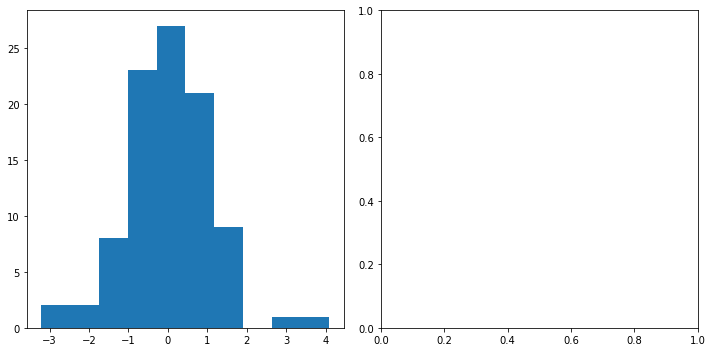

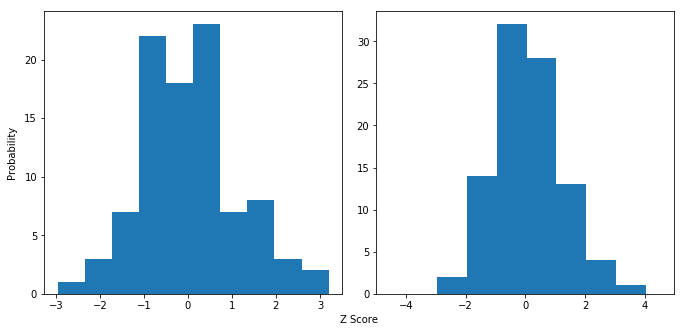

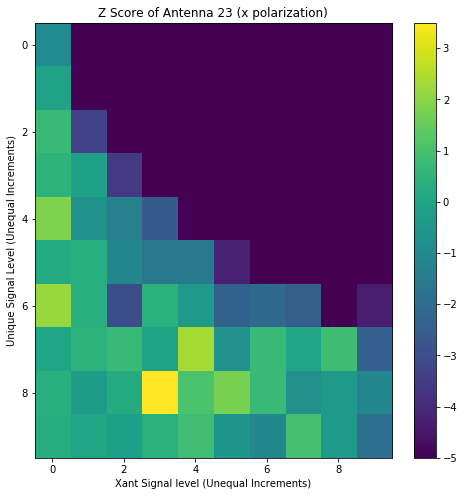

In [60]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto', vmin = -5)
plt.title('Z Score of Antenna 23 (x polarization)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


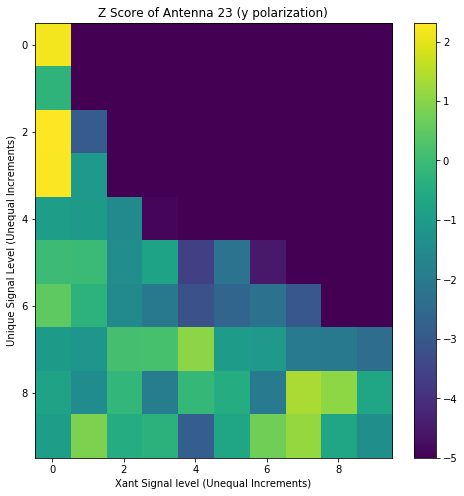

In [61]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto',vmin = -5)
plt.title('Z Score of Antenna 23 (y polarization)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [62]:

avg_array = np.zeros((10,10))

for i in range(len(array_1)):
    
    for j in range(len(array_1[0])):
        
        avg_array[i,j] = (array_1[i][j]+array_2[i][j])/2.
        

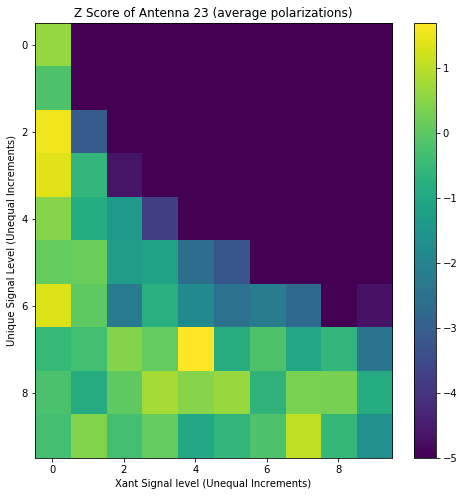

In [63]:

plt.figure(figsize=(8,8))
plt.imshow(avg_array,aspect='auto', vmin = -5)
plt.title('Z Score of Antenna 23 (average polarizations)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


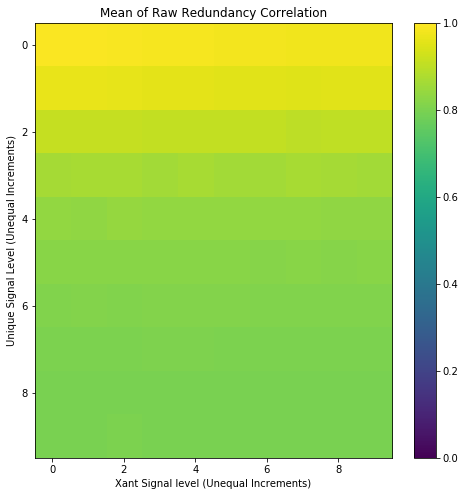

In [64]:

plt.figure(figsize=(8,8))
plt.imshow(array_3,aspect='auto',vmax = 1, vmin = 0)
plt.title('Mean of Raw Redundancy Correlation')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [65]:

slice_0 = []
slice_1 = []
slice_2 = []
slice_3 = []
slice_4 = []
slice_5 = []


for i in range(len(holder_array)):
    
    slice_0.append(holder_array[0][i][0])
    slice_1.append(holder_array[1][i][0])
    slice_2.append(holder_array[2][i][0])
    slice_3.append(holder_array[3][i][0])
    slice_4.append(holder_array[4][i][0])
    slice_5.append(holder_array[5][i][0])
    

In [66]:

avg_0 = []
avg_1 = []
avg_2 = []
avg_3 = []
avg_4 = []
avg_5 = []


for i in range(len(avg_array)):
    
    avg_0.append(avg_array[0][i])
    avg_1.append(avg_array[1][i])
    avg_2.append(avg_array[2][i])
    avg_3.append(avg_array[3][i])
    avg_4.append(avg_array[4][i])
    avg_5.append(avg_array[5][i])
    

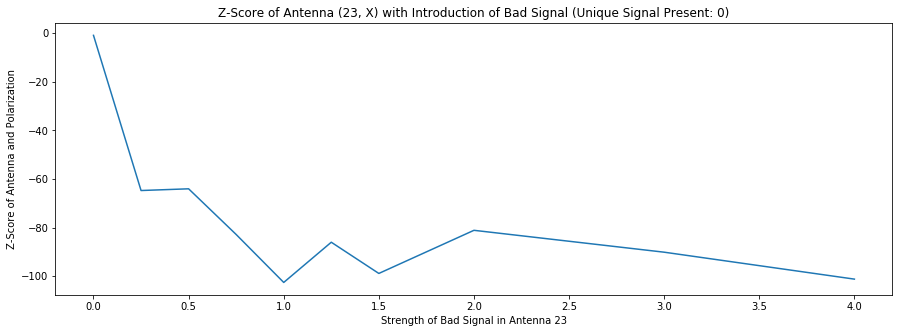

In [67]:

plt.figure(figsize = (15,5))
plt.plot(x_vals,slice_0)
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal (Unique Signal Present: 0)')
plt.show()


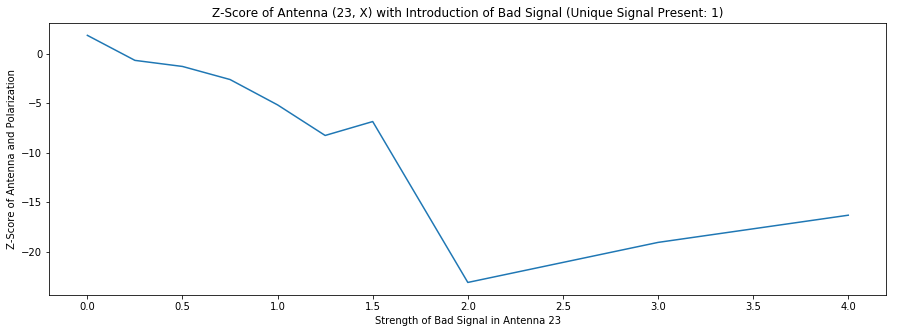

In [68]:

plt.figure(figsize = (15,5))
plt.plot(x_vals,slice_4)
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal (Unique Signal Present: 1)')
plt.show()


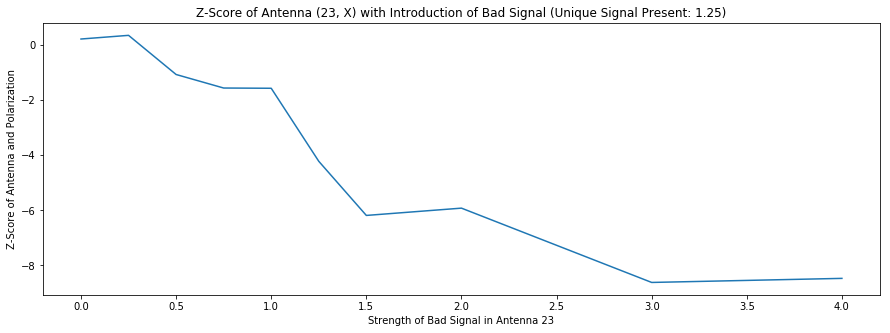

In [69]:

plt.figure(figsize = (15,5))
plt.plot(x_vals,slice_5)
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal (Unique Signal Present: 1.25)')
plt.show()


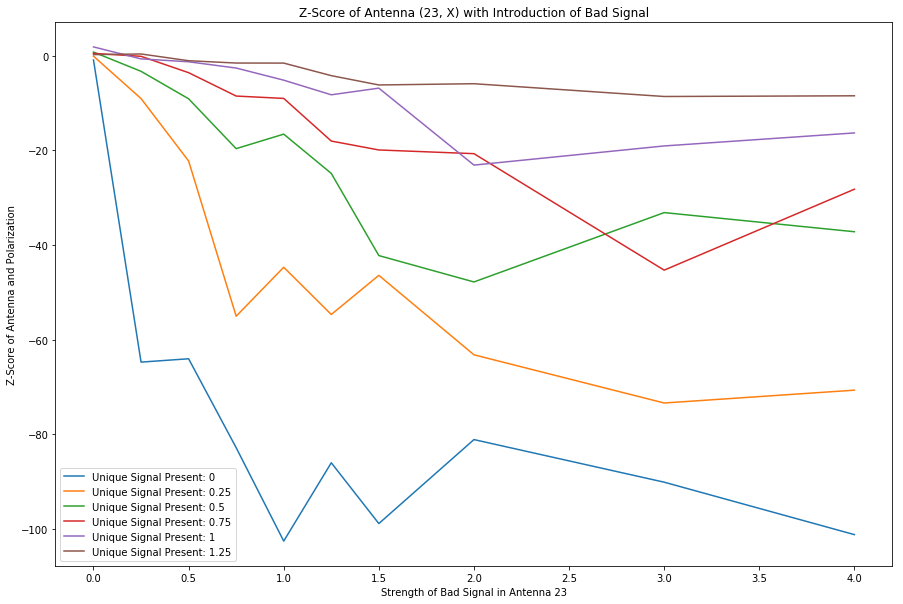

In [70]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.legend()
plt.show()


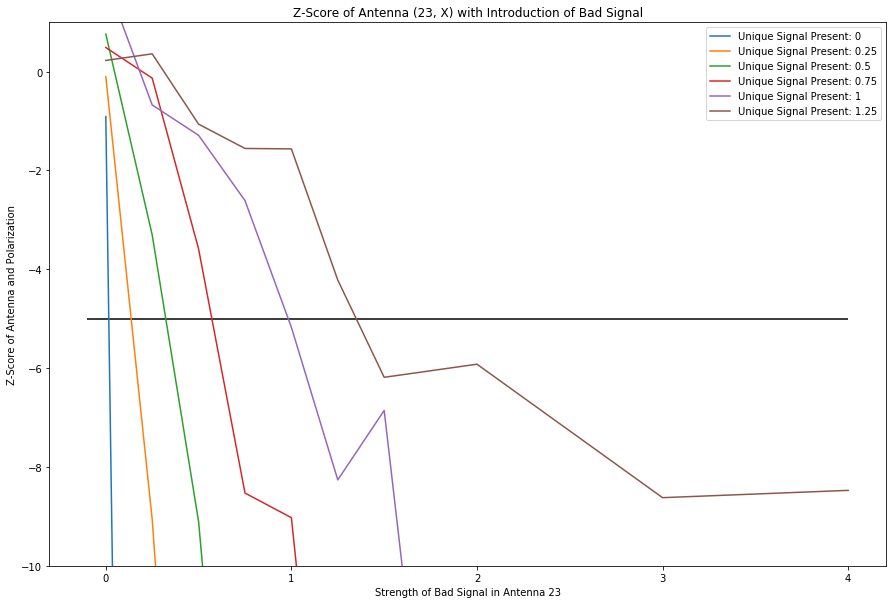

In [71]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()


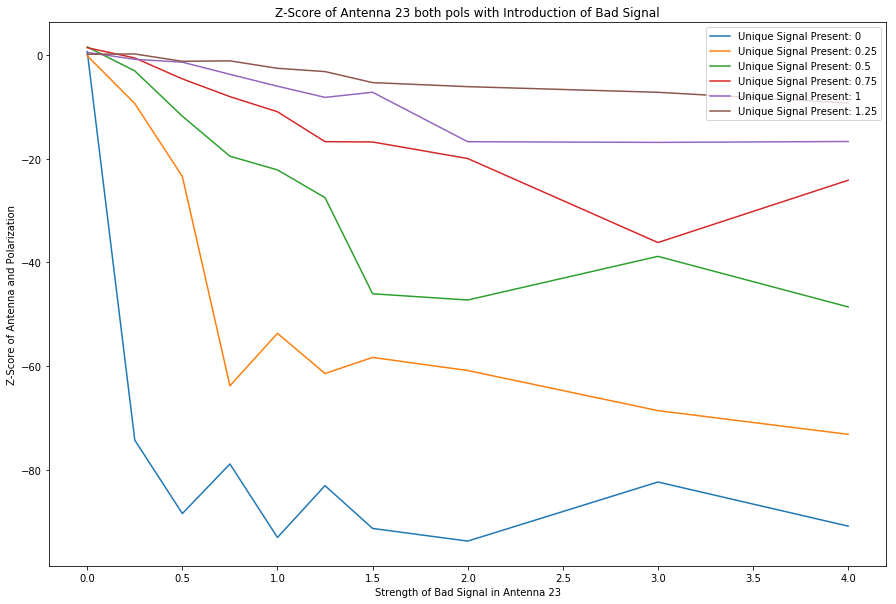

In [72]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.legend()
plt.show()


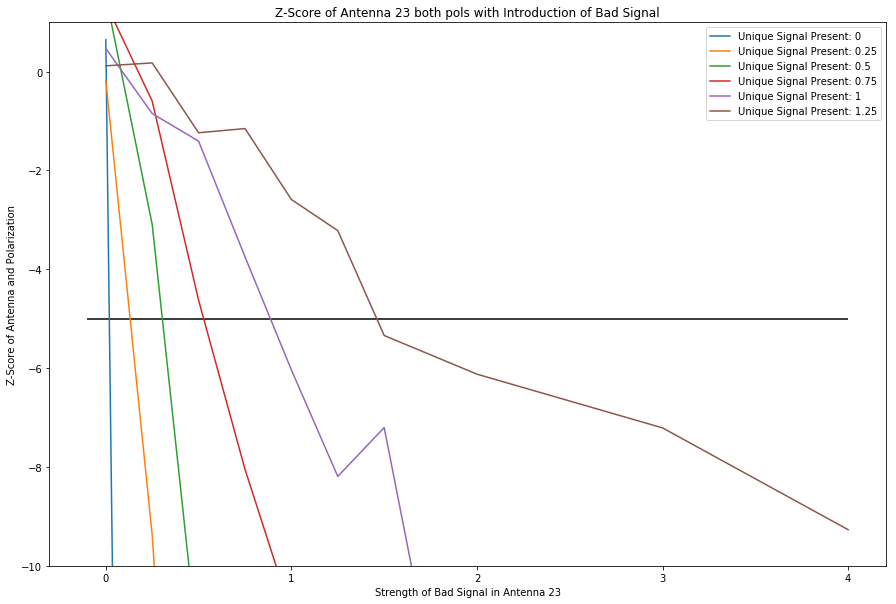

In [73]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()


In [ ]:

#SEFD (System Equivalent Flux Density)

#Possible SNR Values:

#Set 1
#380
#290
#417
#320

#Set 2
#875

#Set 3
#530
#866
#195
#320

#Average:
#466
